This notebook is used to compare GCM data with AWS data, or one GCM against another to look for apparent biases or calibrate parameters to match data. This includes code to calibrate kp (multiplicative precipitation factor) to field winter mass balance data.

In [246]:
import xarray as xr 
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [247]:
# INPUTS
var = 'tp'      # Variable to compare
compare_by = 'region'   # 'region', 'GCM'
GCM = 'MERRA2'  # GCM to extract ('MERRA2','ERA5',' or 'BOTH')
start = pd.to_datetime('2003-01-01 00:00')
end = pd.to_datetime('2018-12-31 00:00')

# necessary initialization
units_checked = False
all_vars = {'temp':{'MERRA2':'T2M','ERA5':'t2m'},
            'tp':{'MERRA2':'PRECTOTCORR','ERA5':'tp'},
            'rh':{'MERRA2':'RH2M','ERA5':'rh'},
            'SWin':{'MERRA2':'SWGDN','ERA5':'ssrd'},
            'LWin':{'MERRA2':'LWGAB','ERA5':'strd'},
            'uwind':{'MERRA2':'U2M','ERA5':'u10'},
            'vwind':{'MERRA2':'V2M','ERA5':'v10'},
            'sp':{'MERRA2':'PS','ERA5':'sp'},
            'tcc':{'MERRA2':'CLDTOT','ERA5':'tcc'},
            'bcwet':{'MERRA2':'BCWT002'},'bcdry':{'MERRA2':'BCDP002'},
            'dustwet':{'MERRA2':'DUWT002'},'dustdry':{'MERRA2':'DUDP002'}}

In [248]:
# GET GLACIER CENLAT
# fill out glac_no and glacier_name for getting AWS data
glac_no = '01.00570' 
glacier_name = 'Gulkana'
# glac_no = '15.03733'
# glacier_name = 'Khumbu'
region = glac_no[:2]

In [249]:
# FILEPATHS
fp_clim = '/home/claire/research/climate_data/'
fp_MERRA2 = os.path.join(fp_clim,'MERRA2/VAR/MERRA2_VAR_LAT_LON.nc')
fp_ERA5 = os.path.join(fp_clim,'ERA5/ERA5_hourly/ERA5_VAR_hourly.nc')
fp_AWS = os.path.join(fp_clim,'AWS/Gulkana/LVL2/gulkana1480_hourly_LVL2.csv')
list_RGI = os.listdir('/home/claire/research/RGI/rgi60/00_rgi60_attribs/')
for file in list_RGI:
    if region in file:
        fp_RGI = '/home/claire/research/RGI/rgi60/00_rgi60_attribs/' + file


In [250]:
# extract lat/lon of glacier
glacier_table = pd.read_csv(fp_RGI)
glacier_table = glacier_table.loc[glacier_table['RGIId'] == 'RGI60-'+glac_no]
cenlat = glacier_table['CenLat'].to_numpy()[0]
cenlon = glacier_table['CenLon'].to_numpy()[0]

In [251]:
def get_point_ds(eds,GCM,var):
    """
    Selects the closest latitude and longitude gridcell
    from a GCM dataset to the input cenlat, cenlon coordinates.
    Also returns the geopotential of that gridcell converted
    to elevation units (m)
    """
    # open GCM dataset
    if GCM in ['MERRA2','BOTH']:
        file_lat = str(int(np.floor(cenlat/10)*10))
        file_lon = str(int(np.floor(cenlon/10)*10))
        fn_MERRA2 = fp_MERRA2.replace('LAT',file_lat).replace('LON',file_lon)
        fn_MERRA2 = fn_MERRA2.replace('VAR',all_vars[var]['MERRA2'])
        ds = xr.open_dataset(fn_MERRA2)
        latname = 'lat'
        lonname = 'lon'
        elevname = 'PHIS'

    if GCM in ['ERA5','BOTH']:
        fn_ERA5 = fp_ERA5.replace('VAR',var)
        ds = xr.open_dataset(fn_ERA5)
        latname = 'latitude'
        lonname = 'longitude'
        elevname = 'z'

    # get latitude and longitude of nearest GCM point
    datalat = ds.coords[latname][:].values
    datalon = ds.coords[lonname][:].values
    lat_nearidx = np.abs(cenlat - datalat).argmin()
    lon_nearidx = np.abs(cenlon - datalon).argmin()
    lat = datalat[lat_nearidx]
    lon = datalon[lon_nearidx]

    if GCM == 'ERA5':
        lat = lat.round(2)
        lon = lon.round(2)
        if var == 'tcc':
            lat = lat.round(1)
            lon = lon.round(1)

    # select dataset by closest lat/lon to glacier center
    ds = ds.sel({latname:lat,lonname:lon}).drop_vars([latname,lonname])
    eds = eds.sel({latname:lat,lonname:lon})
    elev = eds[elevname].to_numpy()[0] / 9.81
    return ds,elev

In [252]:
# RUN FUNCTION TO SELECT DS
if 'MERRA2' == GCM:
    start_M = start + pd.Timedelta(minutes=30)
    end_M = end + pd.Timedelta(minutes=30)
    eds = xr.open_dataset('~/research/climate_data/MERRA2/MERRA2constants.nc4')
    ds_GCM,elev = get_point_ds(eds,GCM,var)
    ds_GCM = ds_GCM.sel(time=pd.date_range(start_M,end_M,freq='h'))
elif 'ERA5' == GCM:
    eds = xr.open_dataset('~/research/climate_data/ERA5/ERA5_hourly/ERA5_geopotential.nc')
    ds_GCM,elev = get_point_ds(eds,GCM,var)
    ds_GCM = ds_GCM.sel(time=pd.date_range(start,end,freq='h'))

In [253]:
# input processing of AWS dataset
AWS_elev = 1480
df_AWS = pd.read_csv(fp_AWS)
df_AWS = df_AWS.set_index(pd.to_datetime(df_AWS['local_time']))
df_AWS.fillna({'Precip_Weighing_Incremental':df_AWS['Precip_Stage_Incremental']*1.48},inplace=True)
df_AWS = df_AWS.loc[pd.date_range(start,end,freq='h')]
# df_AWS = df_AWS['Precip_Weighing_Incremental']
# df_AWS = df_AWS['site_temp_USGS']

In [254]:
# RESAMPLE
if var in ['tp']:
    df_AWS = df_AWS.resample('ME').sum()
    ds_GCM = ds_GCM.resample(time='ME').sum()
if var in ['bcwet','bcdry','dustwet','dustdry']:
    ds_GCM = ds_GCM.resample(time='ME').sum() * 3600
else:
    df_AWS = df_AWS.resample('ME').mean()
    ds_GCM = ds_GCM.resample(time='ME').mean()

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
# ds_GCM_AK = ds_GCM.copy()
# ds_GCM_HMA = ds_GCM.copy()

In [ ]:
# UNITS
if not units_checked:
    if var == 'tp':
        df_AWS['tp'] = df_AWS['Precip_Weighing_Incremental'] / 1000
        ds_GCM = ds_GCM * 3600 / 1000
    elif var == 'temp':
        ds_GCM = ds_GCM - 273.15
        print(f'Adjusting to {AWS_elev - elev:.1f} m elevation change from geopotential to the AWS elevation')
        print(f'(temperature change of {-0.0065*(AWS_elev - elev) :.3f} C)')
        ds_GCM = ds_GCM - 0.0065*(AWS_elev - elev)
    units_checked = True

In [ ]:
# df_AWS = df_AWS.resample('YE').mean()
# ds_GCM = ds_GCM.resample(time='YE').mean()
# ds_GCM_ERA5 = ds_GCM_ERA5.resample(time='YE').mean()

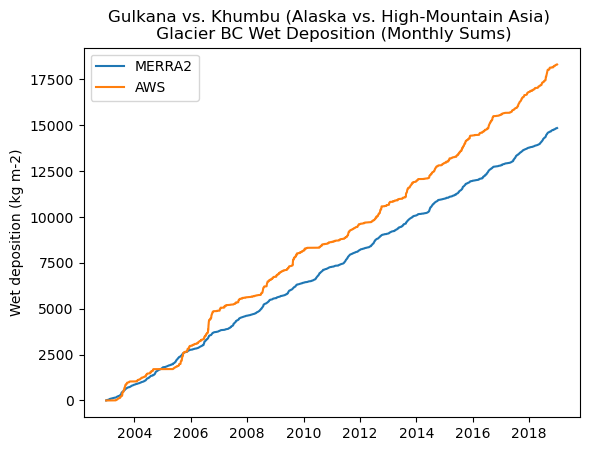

In [ ]:
plot_GCM = ds_GCM[all_vars[var][GCM]].values
df_AWS = df_AWS.fillna(0)
plot_AWS = df_AWS['Precip_Weighing_Incremental'].to_numpy()
if var == 'tp':
    plot_GCM = np.cumsum(plot_GCM)
    plot_AWS = np.cumsum(plot_AWS)
plt.plot(ds_GCM['time'],plot_GCM,label='MERRA2')
# plt.plot(ds_GCM['time'],ds_GCM_HMA[all_vars[var][GCM]].values,label='HMA')
plt.plot(df_AWS.index,plot_AWS,label='AWS')

plt.legend()
plt.title('Gulkana vs. Khumbu (Alaska vs. High-Mountain Asia) \n Glacier BC Wet Deposition (Monthly Sums)')
plt.ylabel('Wet deposition (kg m-2)')
plt.show()